In [71]:
from rich import print
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fp = "/home/numina/Documents/repos/CARL/experiments/attack_on_agents/tmp/2022-06-14/16-27-46/eval_data/eval_data.npz"
eval_data = np.load(fp, allow_pickle=True).item()
context = eval_data["context"]
transitions = eval_data["transitions"]
states = np.array([t[1] for t in transitions])
angles = np.arctan2(states[:, 1], states[:, 0]) % (2 * np.pi)
angles = angles / (2 * np.pi) * 360
angular_velocities = states[:, 2]

plt.scatter(angles, angular_velocities)
plt.show()

plt.hist(angles, bins=50, label="angles")
plt.xlabel(r"$\theta$")
plt.show()

plt.hist(angular_velocities, bins=50, label="velocities")
plt.xlabel(r"$\dot\theta$")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/numina/Documents/repos/CARL/experiments/attack_on_agents/tmp/2022-06-14/16-27-46/eval_data/eval_data.npz'

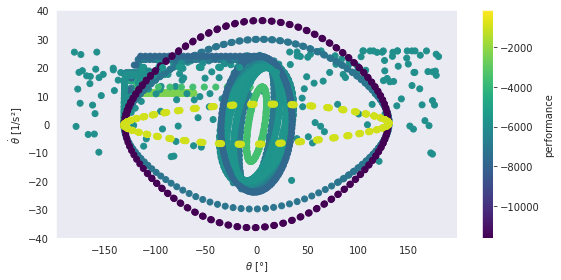

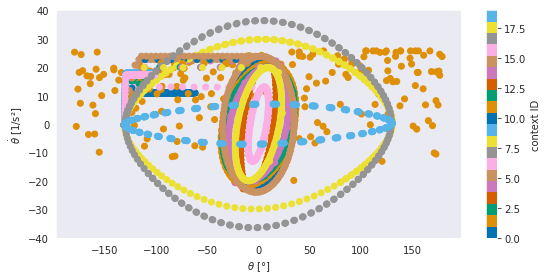

In [17]:
import numpy as np
import glob
import os
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns


def transitions_to_states(transitions):
    states = np.array([t[1] for t in transitions])
    # calculate angle with theta = atan2(y/x) = atan2(sin(theta)/cos(theta))
    angles = np.arctan2(states[:, 1], states[:, 0])
    angles = angles % (2 * np.pi) - np.pi  # move to range -pi, pi
    angles = angles / (2 * np.pi) * 360  # convert radian to degree
    angular_velocities = states[:, 2]
    return angles, angular_velocities


def normalize(A):
    A_min = np.amin(A)
    ptp = np.ptp(A)
    return (A - A_min) / ptp


# Collect all states
# plt.rcParams['axes.grid'] = False

out_dir = "/home/numina/Documents/repos/CARL/experiments/attack_on_agents/tmp/2022-06-14/16-55-48"
eval_data_fps = glob.glob(os.path.join(out_dir, "eval_data/*.npz"))
eval_data_list = [np.load(fp, allow_pickle=True).item() for fp in eval_data_fps]
performance_list = np.array([D["performance"] for D in eval_data_list])
performance_normalized = normalize(performance_list)
state_list = [transitions_to_states(D["transitions"]) for D in eval_data_list]
angle_list = [S[0] for S in state_list]
velocity_list = [S[1] for S in state_list]

P = np.concatenate([[perf] * len(a) for perf, a in zip(performance_list, angle_list)])
Theta = np.concatenate(angle_list)
Theta_dot = np.concatenate(velocity_list)
context_ids = np.concatenate([[i] * len(a) for i, a in enumerate(angle_list)])

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
scatter = ax.scatter(x=Theta, y=Theta_dot, c=P, cmap="viridis")
cbar_label = "performance"
ax.set_xlabel(r"$\theta$ [°]")
ax.set_ylabel(r"$\dot\theta$ [1/s²]")
fig.colorbar(scatter, ax=ax, label=cbar_label)
fig.set_tight_layout(True)
plt.show()

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
cmap = sns.color_palette("colorblind", n_colors=len(np.unique(context_ids)))
cmap = ListedColormap(cmap.as_hex())
scatter = ax.scatter(x=Theta, y=Theta_dot, c=context_ids, cmap=cmap)
cbar_label = "context ID"
ax.set_xlabel(r"$\theta$ [°]")
ax.set_ylabel(r"$\dot\theta$ [1/s²]")
fig.colorbar(scatter, ax=ax, label=cbar_label)
fig.set_tight_layout(True)
plt.show()

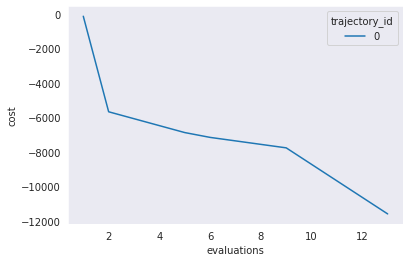

In [13]:
import glob
import os
import json
import pandas as pd


def read_jsonl(fp):
    with open(fp, 'r') as file:
        lines = file.readlines()
    data = [json.loads(l) for l in lines]
    return data

out_dir = "/home/numina/Documents/repos/CARL/experiments/attack_on_agents/tmp/2022-06-14/16-55-48"
smac_folders = glob.glob(os.path.join(out_dir, "smac*", "run_*"), recursive=True)
tj_id = "traj.json"
trajectories = []
for i, smac_folder in enumerate(smac_folders):
    traj_fp = os.path.join(smac_folder, tj_id)
    trajectory = read_jsonl(traj_fp)
    trajectory = pd.DataFrame(trajectory)
    trajectory["trajectory_id"] = i
    trajectory.drop([0], inplace=True)  # drop the first row bc it contains cost of 2e9
    trajectories.append(trajectory)


# trajectories = pd.concat([pd.DataFrame(T) for T in trajectories])
trajectories = pd.concat(trajectories)
fig = plt.figure()
ax = fig.add_subplot(111)
ax = sns.lineplot(data=trajectories, x="evaluations", y="cost", hue="trajectory_id", ax=ax)
plt.show()